In [1]:
import os
import time
import math
import glob
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch

DEVICE = "cuda:0"
SAVE_PATH = 'model/fcdensenet_ba_0.pt'

# set device
device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [2]:
## Creating the dataset

In [3]:
classes = ['Void', 'Grass', 'Decidous', 'Conifers', 'Background']
class_weight = torch.FloatTensor([77.2089729 ,  8.61827954,  2.51466749,  2.29694347, 26.32435424])

class ForestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        #self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['x_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means_wien = np.array([56.003890684524514, 68.57362613839135, 74.81702698592574, 153.3728899964296])
        self.stds_wien = np.array([22.921560008757936, 24.69759936552532, 19.553485949030918, 35.00320612463889])
        
        self.means_mariazell = np.array([52.57864629094064, 63.1731943283136, 59.55804782119867, 101.3607586098534])
        self.stds_mariazell = np.array([37.73983594430985, 35.156998551108586, 25.451356265963383, 47.10539409662177])
        
        #self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # depending on data change mean and std
        #if index < 46868:
        #    means = self.means_wien
        #    stds = self.stds_wien
        #else:
        #    means = self.means_mariazell
        #    stds = self.stds_mariazell
            
        # Load data and get label
        #X = (torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / \
        #     means[:, np.newaxis, np.newaxis]) / stds[:, np.newaxis, np.newaxis]
        
        X = (torch.tensor(self.ortho[index], dtype=torch.float32).permute(2, 0, 1) / 255)
        y = torch.tensor(self.ground_truth[index][:,:,0], dtype=torch.torch.int64)
        
        #X = torch.from_numpy(np.array(self.ortho[index]).transpose(2,0,1)) / 255
        #y = torch.from_numpy(np.array(self.ground_truth[index])[:,:,0], dtype=torch.torch.int64)

        return X, y #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 7)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
path_dataset = "/home/philipp/Data/dataset/dataset_256_ba.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_256_ba.h5"
data = ForestDataset(path_dataset)
len(data)

100000

In [5]:
X, y = data[1000]
X.shape, y.shape

(torch.Size([4, 256, 256]), torch.Size([256, 256]))

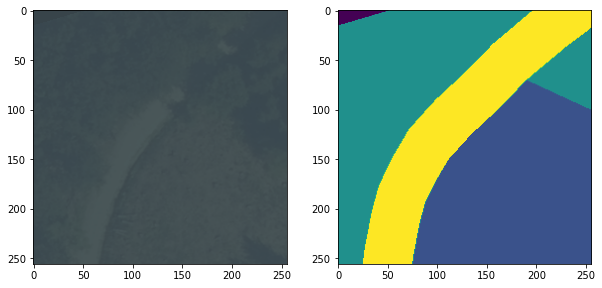

In [6]:
X, y = data[51]
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow((X.permute(1, 2, 0)*data.stds_wien[np.newaxis, np.newaxis, :]+data.means_wien[np.newaxis, np.newaxis, :]).numpy()[:,:,:3].astype('uint8'))
ax[1].imshow(y.numpy())

In [7]:
# split data

In [7]:
batch_size = 8
validation_split = .1
test_split = .1
shuffle_dataset = True
random_seed = 12

# Creating data indices for training and validation splits:
dataset_size = 91000
#dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[2*split:], indices[:split], indices[split:2*split]

print(len(train_indices))
print(len(val_indices))
print(len(test_indices))

72800
9100
9100


In [8]:
# Creating PT data samplers and loaders:
train_sampler = sampler.SubsetRandomSampler(train_indices)
valid_sampler = sampler.SubsetRandomSampler(val_indices)

train_dl = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4)#, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4)#, pin_memory=True)

In [9]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([8, 4, 256, 256]), torch.Size([8, 256, 256]))

In [10]:
## FCDenseNet

In [11]:
import torch
import torch.nn as nn


class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(in_channels))
        self.add_module('relu', nn.ReLU(True))
        self.add_module('conv', nn.Conv2d(in_channels, growth_rate, kernel_size=3,
                                          stride=1, padding=1, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super().forward(x)


class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])

    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x


class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super().__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels, in_channels,
                                          kernel_size=1, stride=1,
                                          padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))

    def forward(self, x):
        return super().forward(x)


class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convTrans = nn.ConvTranspose2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=3, stride=2, padding=0, bias=True)

    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out


class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super().__init__()
        self.add_module('bottleneck', DenseBlock(
            in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super().forward(x)


def center_crop(layer, max_height, max_width):
    _, _, h, w = layer.size()
    xy1 = (w - max_width) // 2
    xy2 = (h - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]


In [12]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5),
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5,
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super().__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        cur_channels_count = 0
        skip_connection_channel_counts = []

        ## First Convolution ##

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels,
                  out_channels=out_chans_first_conv, kernel_size=3,
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv

        #####################
        # Downsampling path #
        #####################

        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))

        #####################
        #     Bottleneck    #
        #####################

        self.add_module('bottleneck',Bottleneck(cur_channels_count,
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels

        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i],
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

        ## Final DenseBlock ##

        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1],
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        ## Softmax ##

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count,
               out_channels=n_classes, kernel_size=1, stride=1,
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.firstconv(x)

        skip_connections = []
        for i in range(len(self.down_blocks)):
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)

        out = self.bottleneck(out)
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            out = self.transUpBlocks[i](out, skip)
            out = self.denseBlocksUp[i](out)

        out = self.finalConv(out)
        out = self.softmax(out)
        return out


def FCDenseNet57(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(4, 4, 4, 4, 4),
        up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4,
        growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet67(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(5, 5, 5, 5, 5),
        up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)


def FCDenseNet103(in_channels, n_classes):
    return FCDenseNet(
        in_channels=in_channels, down_blocks=(4,5,7,10,12),
        up_blocks=(12,10,7,5,4), bottleneck_layers=15,
        growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

DSET_MEAN = [0.41189489566336, 0.4251328133025, 0.4326707089857]
DSET_STD = [0.27413549931506, 0.28506257482912, 0.28284674400252]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
      Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])


def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(DSET_MEAN)
    std = np.array(DSET_STD)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    inp = decode_image(tensor)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [14]:
import os
import sys
import math
import string
import random
import shutil

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F

#from . import imgs as img_utils

RESULTS_PATH = 'results/'
WEIGHTS_PATH = 'weights/'


def save_weights(model, epoch, loss, err):
    weights_fname = 'weights-%d-%.3f-%.3f.pth' % (epoch, loss, err)
    weights_fpath = os.path.join(WEIGHTS_PATH, weights_fname)
    torch.save({
            'startEpoch': epoch,
            'loss':loss,
            'error': err,
            'state_dict': model.state_dict()
        }, weights_fpath)
    shutil.copyfile(weights_fpath, WEIGHTS_PATH+'latest.th')

def load_weights(model, fpath):
    print("loading weights '{}'".format(fpath))
    weights = torch.load(fpath)
    startEpoch = weights['startEpoch']
    model.load_state_dict(weights['state_dict'])
    print("loaded weights (lastEpoch {}, loss {}, error {})"
          .format(startEpoch-1, weights['loss'], weights['error']))
    return startEpoch

def get_predictions(output_batch):
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    values, indices = tensor.cpu().max(1)
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = np.true_divide(incorrect,n_pixels)
    return err

def train(model, trn_loader, optimizer, criterion, epoch):
    model.train()
    trn_loss = 0
    trn_error = 0
    for idx, data in enumerate(trn_loader):
        inputs = Variable(data[0].cuda())
        targets = Variable(data[1].cuda())

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        #trn_loss += loss.data[0]
        trn_loss += loss.data.item()
        pred = get_predictions(output)
        trn_error += error(pred, targets.data.cpu())
        
        if idx % 100 == 0:
            print('Current step: {}  Loss: {}  Acc: {}'.format(idx, loss.data.item(), error(pred, targets.data.cpu())))

    trn_loss /= len(trn_loader)
    trn_error /= len(trn_loader)
    return trn_loss, trn_error

def test(model, test_loader, criterion, epoch=1):
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        
        with torch.no_grad():
            output = model(data)
            test_loss += criterion(output, target).data.item()
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader)
    test_error /= len(test_loader)
    return test_loss, test_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially
        configured `lr` decayed by `decay` every `n_epochs`"""
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform(m.weight)
        m.bias.data.zero_()

def predict(model, input_loader, n_batches=1):
    input_loader.batch_size = 1
    predictions = []
    model.eval()
    for input, target in input_loader:
        data = Variable(input.cuda(), volatile=True)
        label = Variable(target.cuda())
        output = model(data)
        pred = get_predictions(output)
        predictions.append([input,target,pred])
    return predictions

def view_sample_predictions(model, loader, n):
    inputs, targets = next(iter(loader))
    data = Variable(inputs.cuda(), volatile=True)
    label = Variable(targets.cuda())
    output = model(data)
    pred = get_predictions(output)
    batch_size = inputs.size(0)
    for i in range(min(n, batch_size)):
        #img_utils.view_image(inputs[i])
        #img_utils.view_annotated(targets[i])
        #img_utils.view_annotated(pred[i])
        view_image(inputs[i])
        view_annotated(targets[i])
        view_annotated(pred[i])


In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#from models import tiramisu
#from datasets import camvid
#from datasets import joint_transforms
#import utils.imgs
#import utils.training as train_utils

In [16]:
'''
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
utils.imgs.view_annotated(targets[0])
'''

'\nprint("Train: %d" %len(train_loader.dataset.imgs))\nprint("Val: %d" %len(val_loader.dataset.imgs))\nprint("Test: %d" %len(test_loader.dataset.imgs))\nprint("Classes: %d" % len(train_loader.dataset.classes))\n\ninputs, targets = next(iter(train_loader))\nprint("Inputs: ", inputs.size())\nprint("Targets: ", targets.size())\n\nutils.imgs.view_image(inputs[0])\nutils.imgs.view_annotated(targets[0])\n'

In [17]:
# train

In [18]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 3
torch.cuda.manual_seed(0)

In [19]:
model = FCDenseNet57(in_channels=4, n_classes=5).cuda()
try:
    load_weights(model, WEIGHTS_PATH+'latest.th')
    print("weights loaded")
except:
    model.apply(weights_init)
    print("no weights found")
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=class_weight.cuda()).cuda()

loading weights 'weights/latest.th'
loaded weights (lastEpoch 0, loss 0.6172482875382507, error 0.20554907662527902)
weights loaded


In [20]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train(model, train_dl, optimizer, criterion, epoch)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Test ###
    val_loss, val_err = test(model, valid_dl, criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Current step: 0  Loss: 0.932129979133606  Acc: 0.28675270080566406
Current step: 100  Loss: 0.28639981150627136  Acc: 0.1284503936767578
Current step: 200  Loss: 0.4037368595600128  Acc: 0.305206298828125
Current step: 300  Loss: 0.6853160262107849  Acc: 0.1330890655517578
Current step: 400  Loss: 0.9221258759498596  Acc: 0.27851104736328125
Current step: 500  Loss: 0.8469139337539673  Acc: 0.20682716369628906
Current step: 600  Loss: 0.6958416700363159  Acc: 0.2962150573730469
Current step: 700  Loss: 0.8776437640190125  Acc: 0.2774467468261719
Current step: 800  Loss: 0.6959910988807678  Acc: 0.1762676239013672
Current step: 900  Loss: 0.3248819410800934  Acc: 0.240936279296875
Current step: 1000  Loss: 0.37875309586524963  Acc: 0.19582557678222656
Current step: 1100  Loss: 0.47850820422172546  Acc: 0.13234710693359375
Current step: 1200  Loss: 1.5552361011505127  Acc: 0.245635986328125
Current step: 1300  Loss: 0.21596333384513855  Acc: 0.03939056396484375
Current step: 1400  Loss: 

<ipython-input-14-ee4d8bb748d4>:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data.cuda(), volatile=True)


Val - Loss: 0.0681 | Acc: 0.9754
Total Time 50m 54s

Current step: 0  Loss: 0.43706104159355164  Acc: 0.2613639831542969
Current step: 100  Loss: 0.5593119859695435  Acc: 0.2666606903076172
Current step: 200  Loss: 0.2784745395183563  Acc: 0.0584869384765625
Current step: 300  Loss: 0.4971950352191925  Acc: 0.34928321838378906
Current step: 400  Loss: 0.4381544589996338  Acc: 0.18617630004882812
Current step: 500  Loss: 0.5160364508628845  Acc: 0.2113800048828125
Current step: 600  Loss: 0.15531623363494873  Acc: 0.15118789672851562
Current step: 700  Loss: 0.40124690532684326  Acc: 0.2348766326904297
Current step: 800  Loss: 0.6550217270851135  Acc: 0.15525245666503906
Current step: 900  Loss: 0.5929241180419922  Acc: 0.15820884704589844
Current step: 1000  Loss: 0.47891685366630554  Acc: 0.1632366180419922
Current step: 1100  Loss: 0.7362864017486572  Acc: 0.26029205322265625
Current step: 1200  Loss: 0.40027743577957153  Acc: 0.0588531494140625
Current step: 1300  Loss: 0.5821703672

Current step: 2300  Loss: 0.16387023031711578  Acc: 0.24909019470214844
Current step: 2400  Loss: 0.7273319959640503  Acc: 0.18732833862304688
Current step: 2500  Loss: 0.3350682556629181  Acc: 0.08467292785644531
Current step: 2600  Loss: 0.7040117979049683  Acc: 0.19088172912597656
Current step: 2700  Loss: 0.9881626963615417  Acc: 0.2877922058105469
Current step: 2800  Loss: 0.4932335913181305  Acc: 0.24202346801757812
Current step: 2900  Loss: 0.728277325630188  Acc: 0.23575401306152344
Current step: 3000  Loss: 0.20988990366458893  Acc: 0.13917922973632812
Current step: 3100  Loss: 0.32005783915519714  Acc: 0.2795085906982422
Current step: 3200  Loss: 0.8215687274932861  Acc: 0.23550796508789062
Current step: 3300  Loss: 0.5045421719551086  Acc: 0.20149612426757812
Current step: 3400  Loss: 0.18529948592185974  Acc: 0.07449531555175781
Current step: 3500  Loss: 0.31438419222831726  Acc: 0.2806739807128906
Current step: 3600  Loss: 0.6900922656059265  Acc: 0.2152729034423828
Curren

In [ ]:
### Checkpoint ###    
save_weights(model, epoch, val_loss, val_err)

In [ ]:
# test

In [23]:
test(model, test_dl, criterion, epoch=1)  

NameError: name 'test_dl' is not defined

In [ ]:
train_utils.view_sample_predictions(model, test_loader, n=1)